In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import TensorDataset, DataLoader
import tqdm

In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        self.conv1:nn.Conv2d = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2:nn.Conv2d = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1:nn.BatchNorm2d = nn.BatchNorm2d(channels)
        self.norm2:nn.BatchNorm2d = nn.BatchNorm2d(channels)
        self.activation:nn.ReLU = nn.ReLU()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        residual:torch.Tensor = x
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.activation(x + residual)

class SelfAttention(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        self.query:nn.Conv2d = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key:nn.Conv2d = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value:nn.Conv2d = nn.Conv2d(channels, channels, kernel_size=1)
        self.softmax:nn.Softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        B:int = 0 #batch size
        C:int = 0 #nb color chanel
        H:int = 0 # image height
        W:int = 0 # image width

        B, C, H, W = x.shape
        q:torch.Tensor = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        k:torch.Tensor = self.key(x).view(B, -1, H * W)
        v:torch.Tensor = self.value(x).view(B, -1, H * W)
        attention:torch.Tensor = self.softmax(torch.bmm(q, k) / (C ** 0.5))
        out:torch.Tensor = torch.bmm(v, attention.permute(0, 2, 1)).view(B, C, H, W)
        return out + x

class Denoiser(nn.Module):
    def __init__(self, in_channels:int=3, base_channels:int=64) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            ResNetBlock(base_channels),
            SelfAttention(base_channels),
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1),
            ResNetBlock(base_channels * 2),
            SelfAttention(base_channels * 2),
        )
        
        self.middle = ResNetBlock(base_channels * 2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            ResNetBlock(base_channels),
            SelfAttention(base_channels),
            nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1),
        )

    #x.shape <=> [batchSize, in_channels, base_channels, base_channels]
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [8]:
def load_dataset() -> list[torch.Tensor]:
    images_dir:str = os.path.join(os.getcwd(), "Dataset", "64x64")
    images_path:list[str] = os.listdir(images_dir)
    images:list[torch.Tensor] = list[torch.Tensor]()

    for image_local_path in images_path:
        image_absolute_path:str = os.path.join(images_dir, image_local_path)
        image:torch.Tensor = torchvision.io.read_image(image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        images.append(image)

    return images

dataset:list[torch.Tensor] = load_dataset()

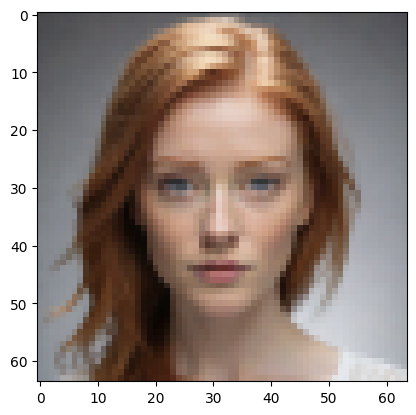

In [9]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)
        image:torch.Tensor = dataset[index]
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
        
plot_dataset_image(1)

In [ ]:
def add_regular_noise(images:torch.Tensor, min_noise_delta:float, max_noise_delta:float, device:str) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = images.shape[0]

    noise = torch.rand(images.shape, device=device)
    noise_deltas = (max_noise_delta - min_noise_delta) * torch.rand(batch_size, device=device) + min_noise_delta
    noise_levels = (torch.rand(batch_size, device=device) * (1.0 - noise_deltas)) + (noise_deltas * 0.5)

    min_noise_levels = noise_levels - (noise_deltas * 0.5)
    max_noise_levels = noise_levels + (noise_deltas * 0.5)

    min_noisy_images = (images * (1.0 - min_noise_levels.view(-1, 1, 1, 1))) + (noise * min_noise_levels.view(-1, 1, 1, 1))
    max_noisy_images = (images * (1.0 - max_noise_levels.view(-1, 1, 1, 1))) + (noise * max_noise_levels.view(-1, 1, 1, 1))

    return min_noisy_images, max_noisy_images

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


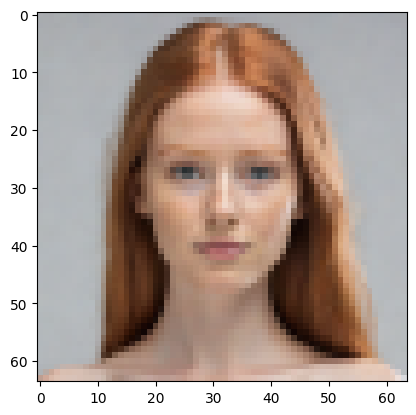

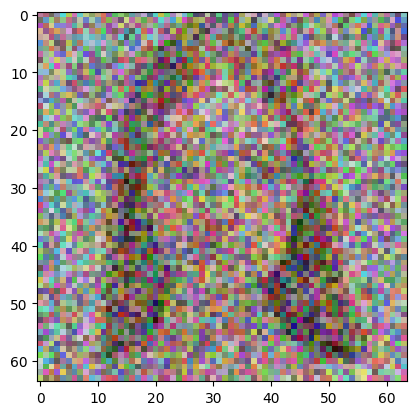

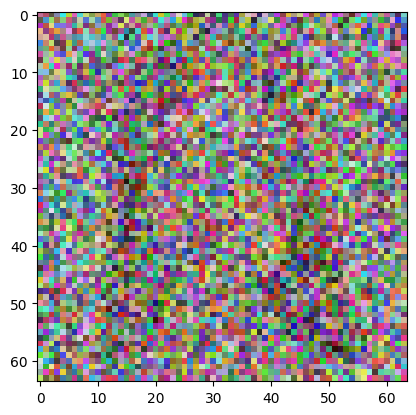

In [32]:
def plot_noisy_images(nb_image:int) -> None:
    images:torch.Tensor = torch.stack([dataset[random.randint(0, len(dataset))] for _ in range(0, nb_image)])
    noisy_images:tuple[torch.Tensor, torch.Tensor] = add_regular_noise(images, 0.05, 0.2, "cpu")
    print(noisy_images[0].shape)
    print(noisy_images[1].shape)

    for i in range(0, len(images)):
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()
        plt.imshow(noisy_images[0][i].permute(1, 2, 0))
        plt.show()
        plt.imshow(noisy_images[1][i].permute(1, 2, 0))
        plt.show()

plot_noisy_images(1)

In [33]:
#training params
lr:float = 0.0001
batch_size:int = 16
epochs:int = 30
test_proportion:float = 0.1
min_noise_delta:float = 0.025
max_noise_delta:float = 0.05
saving_model:bool = True
print_epoch_interval:int = 5
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print("Device : " + device)

Device : cuda


In [34]:
class TrainResult:
    denoiser:Denoiser
    train_losses:list[float]
    test_losses:list[float]

    def __init__(self, denoiser:Denoiser, train_losses:list[float], test_losses:list[float]) -> None:
        self.denoiser = denoiser
        self.train_losses = train_losses
        self.test_losses = test_losses

In [ ]:
def train_denoiser(model:Denoiser, train_dataset:list[torch.Tensor], test_dataset:list[torch.Tensor]) -> TrainResult:

    sample_to_print = min(nb_sample_to_print, batch_size)

    test_dataset = [img.to(device) for img in test_dataset]

    stack_dataset:torch.Tensor = torch.stack(train_dataset).to(device)

    model = model.to(device)

    optimizer:torch.optim.Adam = torch.optim.Adam(model.parameters(), lr = lr)
    criterion:nn.MSELoss = nn.MSELoss()

    train_losses:list[float] = list[float]()
    test_losses:list[float] = list[float]()

    print("Start training denoiser")
    with tqdm.tqdm(total=epochs, desc="Processing") as pbar:
        for epoch in range(0, epochs):
            print_sample = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)

            train_dataset_noise:torch.Tensor = add_regular_noise(stack_dataset, min_noise_delta, max_noise_delta, device)
            tensor_dataset:TensorDataset = TensorDataset(train_dataset_noise[0], train_dataset_noise[1])
            train_loader:DataLoader = DataLoader(tensor_dataset, batch_size = batch_size, shuffle=True)

            for input_batch, expected_output_batch in train_loader:
                optimizer.zero_grad()
                output_batch:torch.Tensor = model(input_batch)
                loss:torch.Tensor = criterion(output_batch, expected_output_batch)
                loss.backward()
                optimizer.step()

                if print_sample:
                    print_sample = False
                    for i in range(0, sample_to_print):
                        noisy_img:torch.Tensor = input_batch[i].cpu().detach()
                        denoise_image:torch.Tensor = output_batch[i].cpu().detach()
                        print("Noisy image :")
                        plt.imshow(noisy_img.permute(1, 2, 0))
                        plt.show()
                        print("Denoise image :")
                        plt.imshow(denoise_image.permute(1, 2, 0))
                        plt.show()

            train_losses.append(loss.item())
            
            output_batch:torch.Tensor = model(train_dataset_noise[0])
            loss:torch.Tensor = criterion(output_batch, train_dataset_noise[1])
            test_losses.append(loss.item())

            if(epoch == 0 or  ((epoch + 1) % print_epoch_interval == 0) or epoch + 1 == epochs):
                print(f"Epoch {epoch+1}, Loss: {loss.item()}")
            
            pbar.update(1)

    if saving_model:
        path = "./Models/denoiser.model"
        if os.path.isfile(path):
            os.remove(path)

        torch.save(model.state_dict(), path)
        print(f"Denoiser Saved!")

    return TrainResult(model, train_losses, test_losses)

train_dataset:torch.Tensor = None
test_dataset:torch.Tensor = None
train_dataset, test_dataset = train_test_split(dataset, test_size = test_proportion, random_state=42, shuffle=True)

denoiser:Denoiser = Denoiser()
train_result:TrainResult = train_denoiser(denoiser, train_dataset, test_dataset)
denoiser = train_result.denoiser

Start training denoiser


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([1154, 3, 64, 64])
torch.Size([1154, 3, 64, 64])


AttributeError: 'NoneType' object has no attribute 'denoiser'

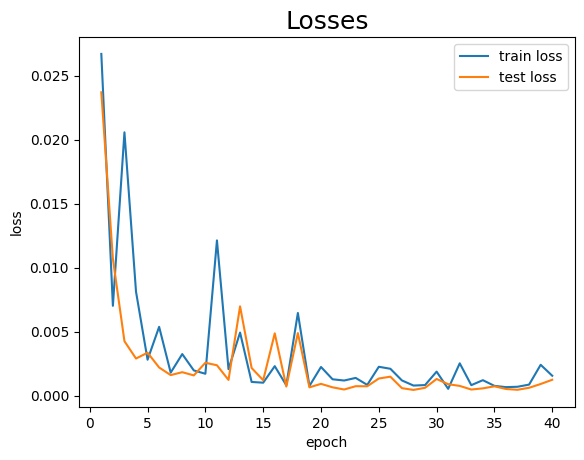

In [11]:
def show_training_result(train_result:TrainResult) -> None:
    X:list[float] = [float(i) for i in range(1, epochs + 1)]
    plt.plot(X, train_result.train_losses, label='train loss')
    plt.plot(X, train_result.test_losses, label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

show_training_result(train_result)

In [12]:
def load_denoiser() -> Denoiser:
    model:Denoiser = Denoiser()
    model_path:str = os.path.join(os.getcwd(), "Models", "denoiser.model")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

denoiser = load_denoiser()

In [13]:
class GenerationParam:
    denoise_step:int
    preview_interval:int
    device:str

    def __init__(self, denoise_step:int, preview_interval:int, device:str) -> None:
        self.denoise_step = denoise_step
        self.preview_interval = preview_interval
        self.device = device

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15883014..0.995358].


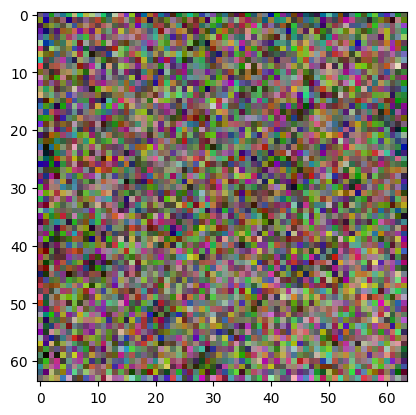

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18249954..0.97005534].


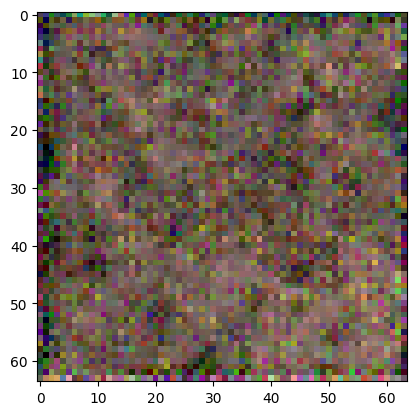

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 38.44 GiB is allocated by PyTorch, and 20.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def generate_face(denoiser:Denoiser, param:GenerationParam) -> torch.Tensor:
    denoiser = denoiser.to(device)
    img:torch.Tensor = torch.rand(1, 3, 64, 64).to(device)
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and (i + 1) % param.preview_interval == 0:
            plot_img:torch.Tensor = img.cpu()[0]
            plot_img = plot_img.detach().permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

def generate_face_bias(denoiser:Denoiser, param:GenerationParam, start_image:torch.Tensor) -> torch.Tensor:
    denoiser = denoiser.to(device)
    img:torch.Tensor = start_image.unsqueeze(1).to(device)
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and (i + 1) % param.preview_interval == 0:
            plot_img:torch.Tensor = img.cpu()[0]
            plot_img = plot_img.detach().permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

params = GenerationParam(50, 5, device)
image:torch.Tensor = generate_face(denoiser, params)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16074166..1.0635941].


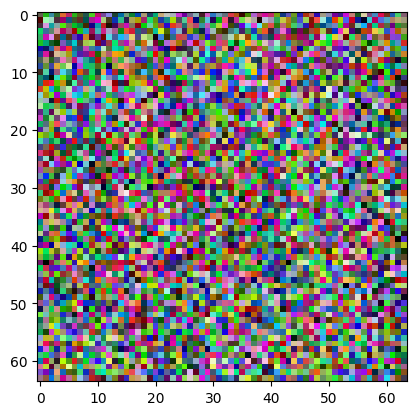

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2947675..1.0964887].


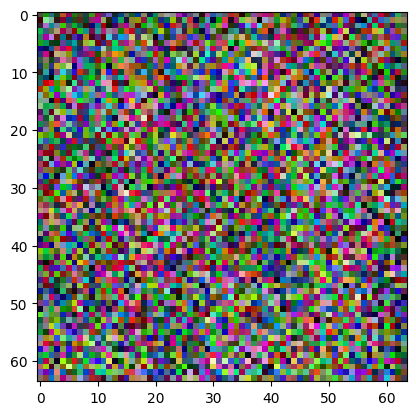

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35259208..1.1265626].


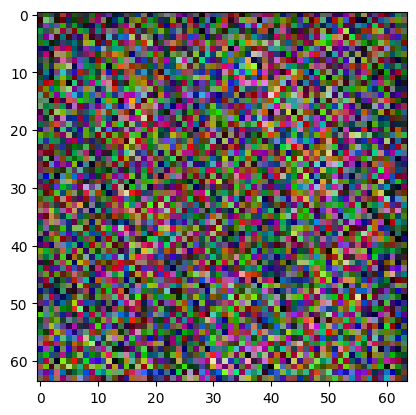

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3677759..1.0962496].


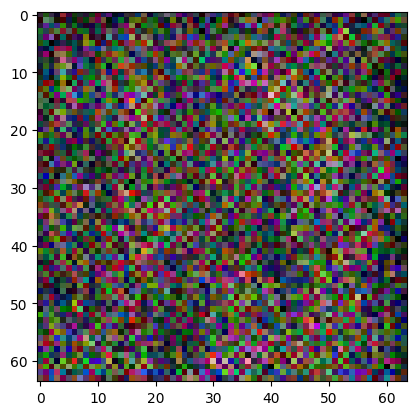

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27512565..0.9668104].


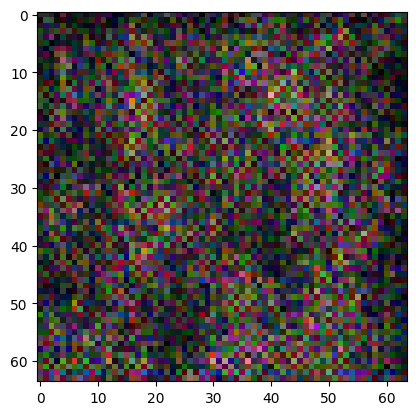

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16828424..0.9035328].


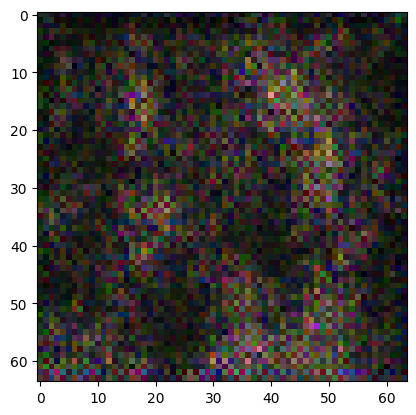

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13870019..0.71640486].


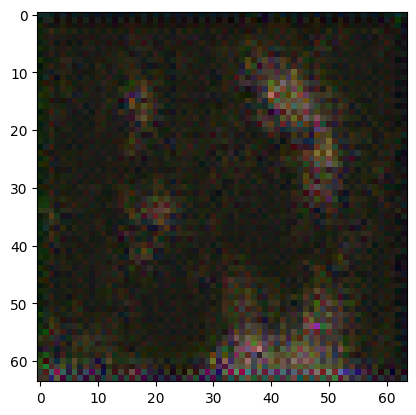

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06049429..0.5560511].


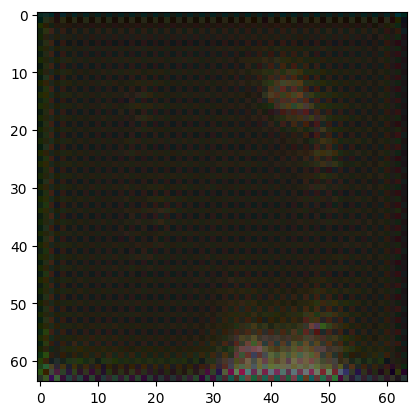

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027966658..0.49212947].


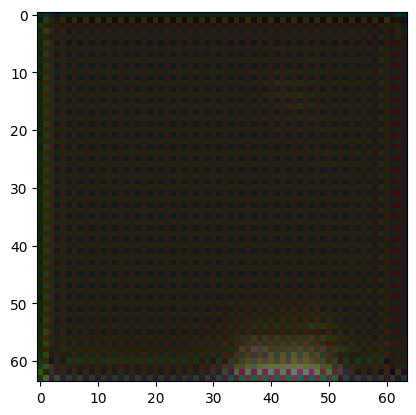

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021688407..0.4786893].


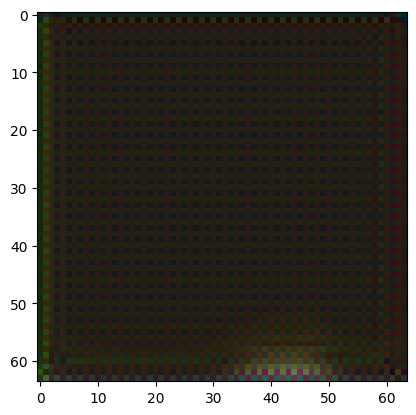

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021688407..0.4786893].


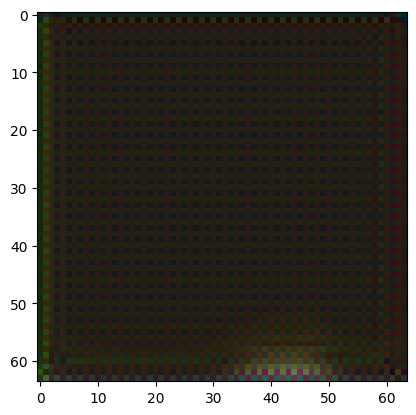

In [ ]:
def generate_face(denoiser:Denoiser, param:GenerationParam) -> torch.Tensor:
    denoiser = denoiser.to(device)
    img:torch.Tensor = torch.rand(1, 3, 64, 64).to(device)
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and (i + 1) % param.preview_interval == 0:
            plot_img:torch.Tensor = img.cpu()[0]
            plot_img = plot_img.detach().permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

params = GenerationParam(20, 2, device)
image:torch.Tensor = generate_face(denoiser, params)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.show()